In [34]:
import os
import openslide
import numpy as np
from PIL import Image
import torch
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from sklearn.model_selection import GridSearchCV, KFold
from skorch import NeuralNetClassifier
import random
from torchvision import models
from skorch.callbacks import EpochScoring
from sklearn.metrics import roc_auc_score
from torch.nn import BCELoss

In [29]:
#Defining training and test data loaders
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def read_svs(path):
    slide = openslide.OpenSlide(path)
    img = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    slide.close()
    img = img.convert('RGB') # convert to RGB channels only
    return img

# define the dataset class
class SVSDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs = []
        self.labels = []
        
        for sub_dir in ["ad", "scc"]:
            dir_path = os.path.join(self.root_dir, sub_dir)
            for img_name in os.listdir(dir_path):
                img_path = os.path.join(dir_path, img_name)
                self.imgs.append(img_path)
                if sub_dir == "ad":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        img = read_svs(img_path)
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.imgs)
    
# define the data transforms
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((299, 299)),  # Resize to 299x299 for InceptionV3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# define the dataset
dataset = SVSDataset(root_dir="/home/bettimj/gamazon_rotation/ashg2022/imaging/all_svs",
                     transform=data_transforms)

# define indices for train and validation sets
num_train = len(dataset)
indices = np.arange(num_train)
np.random.shuffle(indices)
split = int(num_train * 0.1)
train_indices, test_indices = indices[split:], indices[:split]

train_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, sampler=torch.utils.data.SubsetRandomSampler(train_indices, generator=torch.Generator().manual_seed(0)))
test_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, sampler=torch.utils.data.SubsetRandomSampler(test_indices, generator=torch.Generator().manual_seed(0)))

#extract all batches from the data loader
X_train_batches = []
y_train_batches = []
for X_train_batch, y_train_batch in train_loader:
    X_train_batches.append(X_train_batch)
    y_train_batches.append(y_train_batch)

#concatenate all batches into single tensors
X_train = torch.cat(X_train_batches, dim=0)
y_train = torch.cat(y_train_batches, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

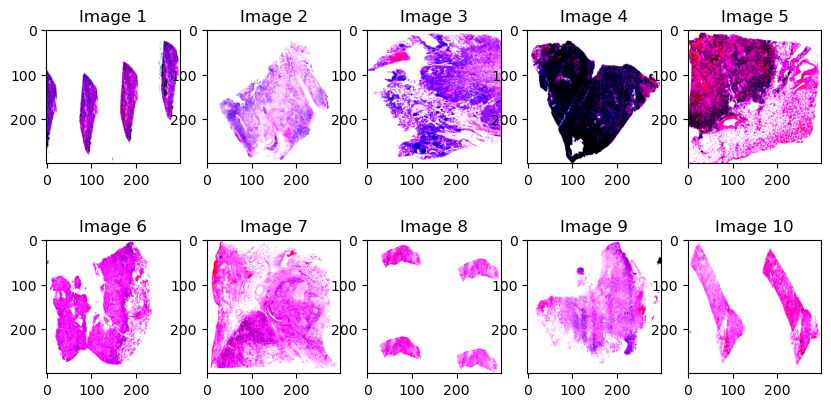

In [30]:
import matplotlib.pyplot as plt

# get the first 10 images from the batch
batch_size = 10
images = next(iter(train_loader))[0][:batch_size]

# plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    # show the image
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f"Image {i+1}")

plt.show()

In [31]:
torch.cuda.is_available()

True

In [45]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

seed_value = 0

# set the random seed for PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define the InceptionV3 architecture and optimize the number of neurons in the fully connected layer
class InceptionV3(nn.Module):
    def __init__(self, hidden_size):
        super(InceptionV3, self).__init__()
        self.model = models.inception_v3(weights = 'DEFAULT')
        self.model.aux_logits = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the neural network
model = NeuralNetClassifier(
    InceptionV3,
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    device='cuda',
    verbose=False,
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid search parameters
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Define the grid search object
clf = GridSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    n_jobs=1,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    verbose=True
)

# Reshape y_train to match the network's output size and convert to float
y_train = y_train.view(-1, 1).float()

# Perform grid search
grid_result = clf.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.549064 using {'module__hidden_size': 10}
0.549064 (0.052652) with: {'module__hidden_size': 10}
0.500000 (0.054426) with: {'module__hidden_size': 20}
0.509501 (0.021884) with: {'module__hidden_size': 30}
0.501437 (0.015475) with: {'module__hidden_size': 40}
0.540015 (0.027053) with: {'module__hidden_size': 50}
0.504817 (0.021522) with: {'module__hidden_size': 60}
0.482731 (0.030735) with: {'module__hidden_size': 70}
0.531815 (0.046061) with: {'module__hidden_size': 80}
0.498925 (0.033029) with: {'module__hidden_size': 90}
0.508435 (0.040403) with: {'module__hidden_size': 100}


In [46]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

seed_value = 0

# set the random seed for PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Define the InceptionV3 architecture
class InceptionV3(nn.Module):
    def __init__(self, hidden_size):
        super(InceptionV3, self).__init__()
        self.model = models.inception_v3(weights = 'DEFAULT')
        self.model.aux_logits = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the neural network
model = NeuralNetClassifier(
    InceptionV3,
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    device='cuda',
    verbose=False,
    module__hidden_size=10,
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

# Define the grid search object
clf = GridSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    n_jobs=1,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    verbose=True
)

# Reshape y_train to match the network's output size and convert to float
y_train = y_train.view(-1, 1).float()

# Perform grid search
grid_result = clf.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.553812 using {'batch_size': 60, 'max_epochs': 40}
0.498706 (0.023569) with: {'batch_size': 10, 'max_epochs': 10}
0.533615 (0.038746) with: {'batch_size': 10, 'max_epochs': 20}
0.516915 (0.064817) with: {'batch_size': 10, 'max_epochs': 30}
0.514750 (0.045881) with: {'batch_size': 10, 'max_epochs': 40}
0.527616 (0.042109) with: {'batch_size': 10, 'max_epochs': 50}
0.488360 (0.068250) with: {'batch_size': 20, 'max_epochs': 10}
0.496985 (0.041331) with: {'batch_size': 20, 'max_epochs': 20}
0.509614 (0.032616) with: {'batch_size': 20, 'max_epochs': 30}
0.532285 (0.050783) with: {'batch_size': 20, 'max_epochs': 40}
0.504849 (0.014713) with: {'batch_size': 20, 'max_epochs': 50}
0.507298 (0.043372) with: {'batch_size': 40, 'max_epochs': 10}
0.502520 (0.063613) with: {'batch_size': 40, 'max_epochs': 20}
0.507879 (0.036561) with: {'batch_size': 40, 'max_epochs': 30}
0.500883 (0.015720) with: {'batch_size': 40, 'max_epochs': 40

In [47]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

seed_value = 0

# set the random seed for PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Optimizing learning rate and weight decay
class InceptionV3(nn.Module):
    def __init__(self):
        super(InceptionV3, self).__init__()
        self.model = models.inception_v3(weights = 'DEFAULT')
        self.model.aux_logits = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the neural network
model = NeuralNetClassifier(
    InceptionV3,
    batch_size=60,
    max_epochs=40,
    criterion=nn.BCELoss,
    #optimizer=optim.Adam,
    device='cuda',
    verbose=False,
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid search parameters
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam]
}

# Define the grid search object
clf = GridSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    n_jobs=1,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    verbose=True
)

# Reshape y_train to match the network's output size and convert to float
y_train = y_train.view(-1, 1).float()

# Perform grid search
grid_result = clf.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.771066 using {'optimizer': <class 'torch.optim.sgd.SGD'>}
0.771066 (0.028211) with: {'optimizer': <class 'torch.optim.sgd.SGD'>}
0.523327 (0.045176) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
0.502676 (0.064759) with: {'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
0.769675 (0.024631) with: {'optimizer': <class 'torch.optim.adadelta.Adadelta'>}
0.534084 (0.057284) with: {'optimizer': <class 'torch.optim.adam.Adam'>}
0.522949 (0.042167) with: {'optimizer': <class 'torch.optim.adamax.Adamax'>}
0.528903 (0.051755) with: {'optimizer': <class 'torch.optim.nadam.NAdam'>}


In [49]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

seed_value = 0

# set the random seed for PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Optimizing learning rate and weight decay
class InceptionV3(nn.Module):
    def __init__(self):
        super(InceptionV3, self).__init__()
        self.model = models.inception_v3(weights = 'DEFAULT')
        self.model.aux_logits = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the neural network
model = NeuralNetClassifier(
    InceptionV3,
    batch_size=60,
    max_epochs=40,
    criterion=nn.BCELoss,
    optimizer=optim.SGD,
    device='cuda',
    verbose=False,
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid search parameters
param_grid = {
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.005, 0.01, 0.1, 0.2, 0.3],
    'optimizer__weight_decay': [0.0, 0.01, 0.001]
}

# Define the grid search object
clf = GridSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    n_jobs=1,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    verbose=True
)

# Reshape y_train to match the network's output size and convert to float
y_train = y_train.view(-1, 1).float()

# Perform grid search
grid_result = clf.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best: 0.814611 using {'optimizer__lr': 0.1, 'optimizer__weight_decay': 0.01}
0.554822 (0.047975) with: {'optimizer__lr': 0.0001, 'optimizer__weight_decay': 0.0}
0.576002 (0.051511) with: {'optimizer__lr': 0.0001, 'optimizer__weight_decay': 0.01}
0.539790 (0.048279) with: {'optimizer__lr': 0.0001, 'optimizer__weight_decay': 0.001}
0.663933 (0.034411) with: {'optimizer__lr': 0.0005, 'optimizer__weight_decay': 0.0}
0.695009 (0.032670) with: {'optimizer__lr': 0.0005, 'optimizer__weight_decay': 0.01}
0.665875 (0.055345) with: {'optimizer__lr': 0.0005, 'optimizer__weight_decay': 0.001}
0.715979 (0.040431) with: {'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0}
0.721932 (0.033875) with: {'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.01}
0.715233 (0.020902) with: {'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
0.731808 (0.023674) with: {'optimizer__lr': 0.005, 'optimizer__weight_decay': 0.0}
0.745242 (0.0232

Text(0.5, 1.0, 'Training and Validation AUC')

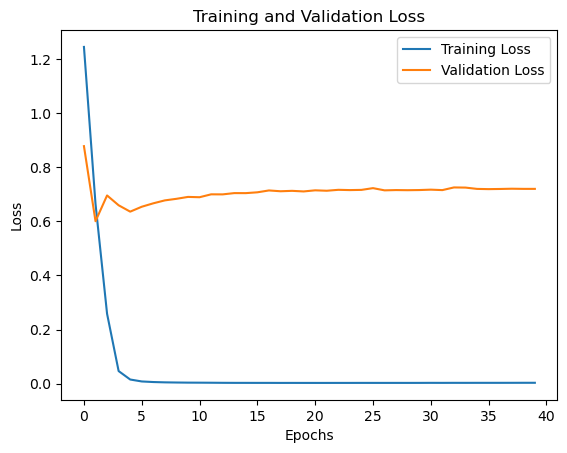

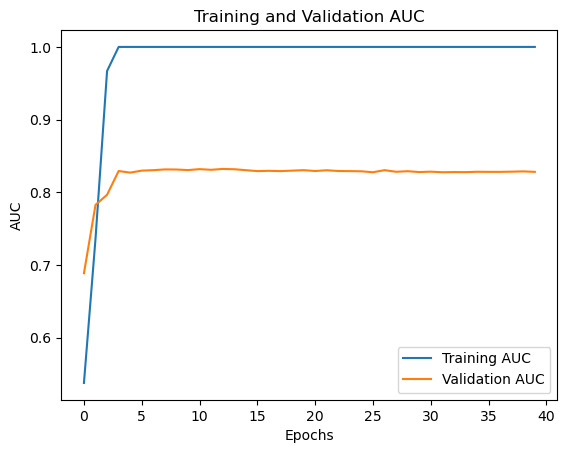

In [50]:
import matplotlib.pyplot as plt

# get the best estimator
best_estimator = grid_result.best_estimator_
#print(best_estimator.history)

# get training and validation loss and AUC
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_auc = best_estimator.history[:, 'train_auc']
val_auc = best_estimator.history[:, 'valid_auc']

# plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# plot the training and validation AUC curves
plt.figure()
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')

In [51]:
best_estimator = grid_result.best_estimator_
print(best_estimator)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=InceptionV3(
    (model): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchN

In [52]:
best_model = grid_result.best_estimator_.module_
# Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'best_imaging_cnn_inceptionv3_model.h5')

In [53]:
# Evaluate performance on test set
#extract all batches from the data loader
X_test_batches = []
y_test_batches = []
for X_test_batch, y_test_batch in test_loader:
    X_test_batches.append(X_test_batch)
    y_test_batches.append(y_test_batch)

#concatenate all batches into single tensors
X_test = torch.cat(X_test_batches, dim=0)
y_test = torch.cat(y_test_batches, dim=0)

y_pred = best_model(X_test.to("cuda"))
auc = roc_auc_score(y_test, y_pred.detach().cpu().numpy())

print(auc)

0.8063829787234043
